In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats
from datetime import datetime

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error

# Data selection

### Collecting bitcoin close data

In [2]:
data_folder = './g-research-crypto-forecasting/'

asset_details = pd.read_csv(data_folder + 'asset_details.csv')

train = pd.read_csv(data_folder + 'train.csv')

train.head()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,1514764860,2,40.0,2376.5800,2399.5000,2357.1400,2374.5900,19.233005,2373.116392,-0.004218
1,1514764860,0,5.0,8.5300,8.5300,8.5300,8.5300,78.380000,8.530000,-0.014399
2,1514764860,1,229.0,13835.1940,14013.8000,13666.1100,13850.1760,31.550062,13827.062093,-0.014643
3,1514764860,5,32.0,7.6596,7.6596,7.6567,7.6576,6626.713370,7.657713,-0.013922
4,1514764860,7,5.0,25.9200,25.9200,25.8740,25.8770,121.087310,25.891363,-0.008264


In [3]:
def collect_close_data(asset_id, data = train):
    df = data[data['Asset_ID'] == asset_id].reset_index(drop = True)
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
    df = df.set_index('timestamp')
    asset_name = asset_details.loc[asset_details['Asset_ID'] == asset_id]['Asset_Name'].values[0]
    df = df.rename(columns = { 'Close': asset_name })
    return pd.DataFrame(df[asset_name])

btc = collect_close_data(asset_id=1)
btc.head()

,Bitcoin
timestamp,
2018-01-01 00:01:00,13850.176
2018-01-01 00:02:00,13828.102
2018-01-01 00:03:00,13801.314
2018-01-01 00:04:00,13768.040
2018-01-01 00:05:00,13724.914


### Bitcoin close data visualization

<AxesSubplot:title={'center':'overall Bitcoin close price in USD'}, xlabel='timestamp'>

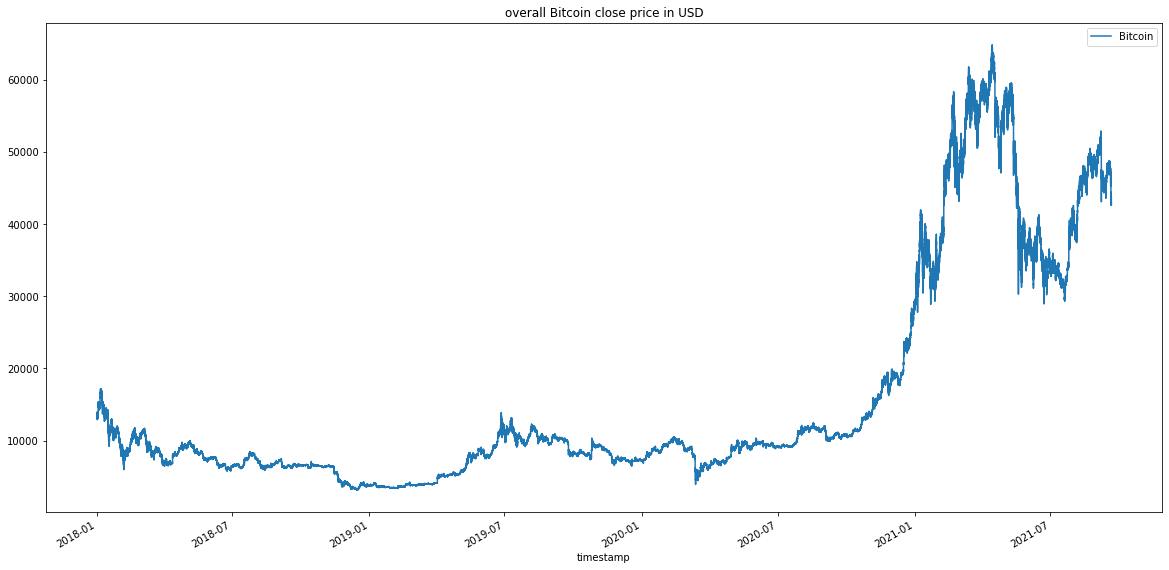

In [4]:
btc.plot(figsize=(20, 10), title="overall Bitcoin close price in USD")

### Creating intervals datasets

In [5]:
btc2020 = btc.loc["01/01/2020": "12/31/2020"]

btc2020_dec = btc.loc["12/01/2020": "12/31/2020"]

btc2020_lastday = btc.loc["12/31/2020": "12/31/2020"]

### Data normalization

In [6]:
data = btc.resample("M").mean()
data["box"], lmbda=stats.boxcox(data.Bitcoin)
data["close"] = data["box"].diff()
data.index.freq=None
data

,Bitcoin,box,close
timestamp,,,
2018-01-31,12874.810724,1.894840,NaN
2018-02-28,9388.844620,1.892430,-0.002410
2018-03-31,9021.126575,1.892095,-0.000334
2018-04-30,7982.553371,1.891027,-0.001068
2018-05-31,8439.249120,1.891521,0.000494
2018-06-30,6782.337171,1.889493,-0.002028
2018-07-31,7097.937907,1.889934,0.000441
2018-08-31,6689.605841,1.889357,-0.000577
2018-09-30,6593.544763,1.889214,-0.000144


<AxesSubplot:xlabel='timestamp'>

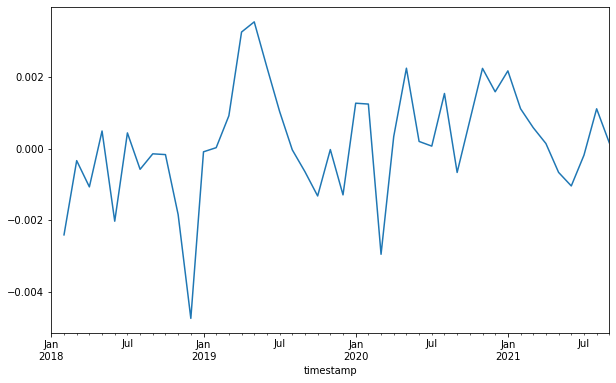

In [7]:
data["close"].plot(figsize=(10, 6))

### Autocorr graphs

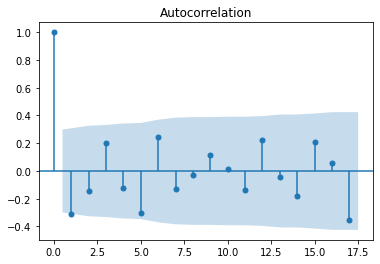

In [8]:
_ = plot_acf(data["close"].diff(periods=1).dropna())

### Split to train and test datasets

In [9]:
data_train = data.iloc[:30]
data_test = data.iloc[30:]

### Creating model

In [10]:
model = SARIMAX(data_train["close"].iloc[1:], order=(2, 1, 1))
arima_result = model.fit(disp=0)
print(arima_result.summary())

                               SARIMAX Results                                
Dep. Variable:                  close   No. Observations:                   29
Model:               SARIMAX(2, 1, 1)   Log Likelihood                 136.636
Date:                Wed, 13 Apr 2022   AIC                           -265.272
Time:                        03:37:10   BIC                           -259.943
Sample:                    02-28-2018   HQIC                          -263.643
                         - 06-30-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5053      0.715     -0.707      0.480      -1.907       0.896
ar.L2         -0.3245      0.265     -1.226      0.220      -0.843       0.194
ma.L1          0.1170      0.704      0.166      0.8

C:\Users\Crews\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\Crews\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'
C:\Users\Crews\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Crews\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


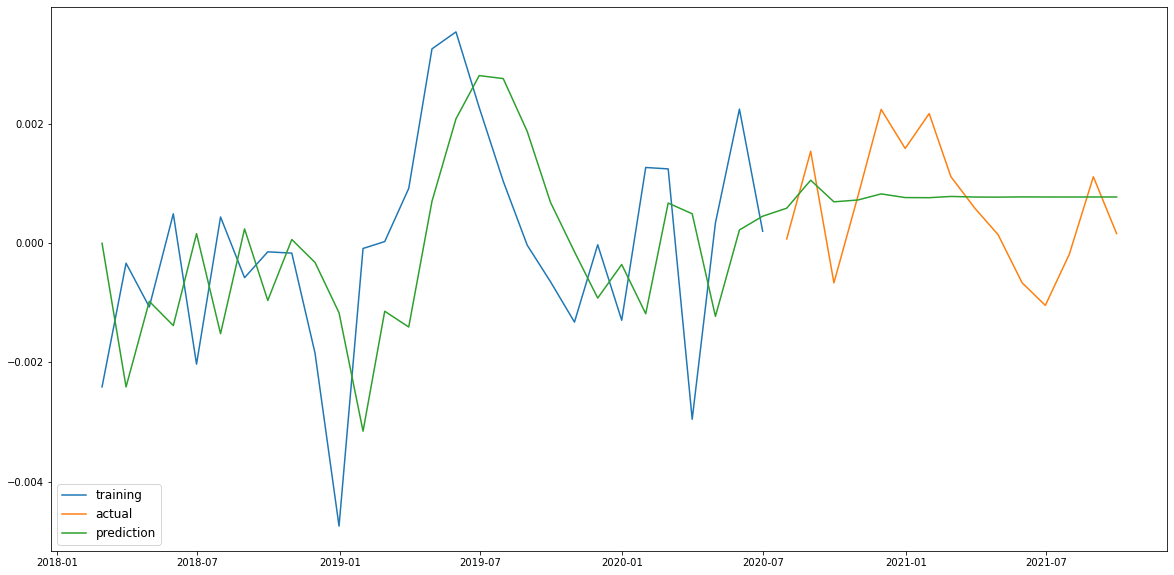

In [11]:
pd1, _, _ = arima_result.forecast(3)
pd1_series = pd.Series(pd1, index=data_test.index)

pd2 = arima_result.predict(start=data_train.index[1], end=data_test.index[-1])
pd2_series = pd.Series(pd2, index=data.index[1:])

plt.figure(figsize=(20, 10))
plt.plot(data_train["close"].iloc[1:], label="training")
plt.plot(data_test["close"], label="actual")
#plt.plot(pd1_series, label="forecast")
plt.plot(pd2_series, label="prediction")
plt.legend(loc='lower left', fontsize=12)
plt.show()

In [12]:
print("MSE: {:f}".format(float(mean_squared_error(data.close[1:], pd2))))

MSE: 0.000003
